In [1]:
import sys
#sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2
#from pytube import YouTube
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from PIL import Image
import glob

%matplotlib inline

# Target

In [2]:
def get_target_stats(path) :
    image_list = []
    min_ankle_array = np.empty([len(glob.glob(str(path)+'/*'))])
    height_array = np.empty([len(glob.glob(str(path)+'/*'))])
    #print(height_array.shape)
    i=0
    for filename in glob.glob(str(path)+'/*'):
        #print(filename)
        target_label = np.asarray(cv2.imread(filename))
        target_label = target_label[:,:,0]
        height_non_zero_array = (~np.all(target_label == 0, axis=1))
        target_ankle = np.max(np.where(height_non_zero_array == 1))
        target_head = np.min(np.where(height_non_zero_array == 1))
        min_ankle_array[i] = target_ankle
        target_height = target_ankle-target_head+1
        height_array[i] = target_height
        i = i+1
        if(i%500 == 0):
            print("Working for image : "+str(i))
            plt.imshow(target_label)
            plt.show()
        #im=Image.open(filename)
        #image_list.append(im)
    avg_min_ankle_target = np.mean(min_ankle_array).astype(np.int16)
    avg_height_target = np.mean(height_array).astype(np.int16)
    return avg_min_ankle_target,avg_height_target

In [3]:
path = "../data/target/train_label"
#target_ankle, target_height = get_target_stats(path)
target_ankle=487
target_height=336
print(target_ankle,target_height)

487 336


# Source

In [4]:
def normalize(source_img,avg_min_ankle_target,avg_height_target) :
    #takes in the heatmap of the source and returns the source's heatmap normalized according to target
    source_img = np.asarray(source_img)[:,:,0]
    height_points = (~np.all(source_img == 0, axis=1))
    width_points = (~np.all(source_img == 0, axis=0))
    ankle = np.max(np.where(height_points == 1))
    head = np.min(np.where(height_points == 1))
    right = np.max(np.where(width_points == 1))
    left = np.min(np.where(width_points == 1))
    source_height = ankle-head+1
    #print("Height of the source is : "+str(source_height))
    source_width = right-left+1
    #print("Width of the source is : "+str(source_width))
    source_ankle = ankle
    source_center_width = int(left+(source_width/2))
    source_center_height = int(head+(source_height/2))
    #print("Center of the source : "+str(source_center_width)+", "+str(source_center_height))
    #print("Ankle of the source is at : "+str(source_ankle))
    cropped_source_img = source_img[head:ankle+1,left:right+1]
    height_ratio = avg_height_target/source_height
    #print("target : source = 1:"+str(height_ratio))
    new_cropped_img = cv2.resize(cropped_source_img,(int(source_width*height_ratio),int(source_height*height_ratio)))
    #print("Height and width of new image : "+str(new_cropped_img.shape))
    new_height = new_cropped_img.shape[0]
    new_width = new_cropped_img.shape[1]
    x = int(source_center_width-(new_width/2))
    y = int(avg_min_ankle_target-new_height)
    #print(x,y)
    new_label = np.zeros([source_img.shape[0],source_img.shape[1]])
    new_label[y:y+new_height,x:x+new_width] = new_cropped_img
    return new_label

In [5]:
path ="../data/source/test_label"
norm_path="../data/source/norm/test_label"
idx=0;
for filename in glob.glob(str(path)+'/*'):
        #print(filename)
    source_img = cv2.imread(filename)
    test_img = normalize(source_img, target_ankle, target_height)
    name = filename[-8:]
    print(name)
    cv2.imwrite((str(norm_path)+'/label_'+name), test_img)  
    idx+=1

0124.png
0123.png
0118.png
0119.png
0117.png
0122.png
0121.png
0120.png


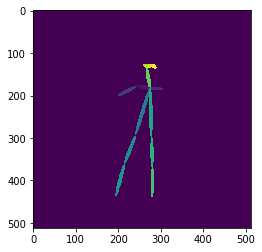

In [6]:
plt.imshow(source_img[:,:,0])

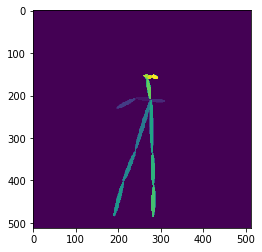

In [7]:
plt.imshow(test_img)